In [48]:
import pandas as pd
import regex as re
import matplotlib.pyplot as plt
from nltk import download
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import RandomizedSearchCV

In [49]:
df = pd.read_csv("https://breathecode.herokuapp.com/asset/internal-link?id=932&path=url_spam.csv")

In [50]:
df

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,True
1,https://www.hvper.com/,True
2,https://briefingday.com/m/v4n3i4f3,True
3,https://briefingday.com/n/20200618/m#commentform,False
4,https://briefingday.com/fan,True
...,...,...
2994,https://www.smartcitiesworld.net/news/news/dee...,False
2995,https://www.youtube.com/watch,True
2996,https://techcrunch.com/2019/07/04/an-optimisti...,False
2997,https://www.technologyreview.com/2019/12/20/13...,False


# Procesamiento de datos

Transformamos nuestras dos categorías `spam` y `ham` en valores numéricos (`0` y `1`), ya que este, como la mayoría de los modelos, no trabajan con variables de clase categóricas:

In [51]:
df.dtypes

url        object
is_spam      bool
dtype: object

In [52]:
df["is_spam"] = df["is_spam"].astype(int)

df

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,1
1,https://www.hvper.com/,1
2,https://briefingday.com/m/v4n3i4f3,1
3,https://briefingday.com/n/20200618/m#commentform,0
4,https://briefingday.com/fan,1
...,...,...
2994,https://www.smartcitiesworld.net/news/news/dee...,0
2995,https://www.youtube.com/watch,1
2996,https://techcrunch.com/2019/07/04/an-optimisti...,0
2997,https://www.technologyreview.com/2019/12/20/13...,0


In [53]:
df.dtypes


url        object
is_spam     int64
dtype: object

Debemos eliminar también los duplicados, si los hubiera:

In [54]:
df.shape

(2999, 2)

In [55]:
df = df.drop_duplicates()
df = df.reset_index(inplace=False, drop=True)
df.shape

(2369, 2)

# Procesamiento del texto

Para poder entrenar el modelo es necesario aplicar antes un proceso de transformación al texto. Comenzamos transformando el texto a minúsculas y eliminando signos de puntuación y caracteres especiales:

## Cleaning

In [56]:
def preprocess_text(text):
    text = text.lower()
    # Reemplaza el contenido de las etiquetas (tags) html por <>
    text = re.sub("</?.*?>", " <> ", text)
    # Reemplaza aquello que no es una letra (a-z) o un espacio en blanco por un espacio en blanco
    text = re.sub(r'[^a-z ]', " ", text)
    # Reemplaza múltiples espacios en blanco en uno solo
    text = re.sub(r'\s+', " ", text)
    return text.split()

In [57]:
df["url"] = df["url"].apply(preprocess_text)
df

,url,is_spam
0,"[https, briefingday, us, list, manage, com, un...",1
1,"[https, www, hvper, com]",1
2,"[https, briefingday, com, m, v, n, i, f]",1
3,"[https, briefingday, com, n, m, commentform]",0
4,"[https, briefingday, com, fan]",1
...,...,...
2364,"[https, www, theverge, com, disney, deepfake, ...",0
2365,"[https, www, smartcitiesworld, net, news, news...",0
2366,"[https, techcrunch, com, an, optimistic, view,...",0
2367,"[https, www, technologyreview, com, this, star...",0


## lematizacion

El siguiente paso es la **lematización del texto**, que es el proceso de simplificación de las palabras a su forma base o canónica, de manera que palabras con diferentes formas, pero el mismo núcleo semántico, se traten como una sola palabra.

Además, aprovechando la lematización, eliminaremos también las **stopwords**, que son palabras que consideramos irrelevantes para el análisis de texto porque aparece con mucha frecuencia en el lenguaje y no aporta información significativa. Existen dos formas: crear nosotros nuestra propia lista de palabras a eliminar o utilizar librerías externas.

Ambas tareas las llevaremos a cabo con la librería de Python `NLTK`, que es una de las más importantes en términos del NLP:

In [58]:
# Instancia lematizador
download("wordnet")
lemmatizer = WordNetLemmatizer()

download("stopwords")
stop_words = stopwords.words("english")

def lemmatize_text(words, lemmatizer=lemmatizer):
    # lematiza
    tokens = [lemmatizer.lemmatize(word) for word in words]
    # saca stop words
    tokens = [word for word in tokens if word not in stop_words]
    # se queda con las de largo mayor a
    tokens = [word for word in tokens if len(word) > 3]
    return tokens

[nltk_data] Downloading package wordnet to /home/vscode/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [59]:
df["url"] = df["url"].apply(lemmatize_text)
df

,url,is_spam
0,"[http, briefingday, list, manage, unsubscribe]",1
1,"[http, hvper]",1
2,"[http, briefingday]",1
3,"[http, briefingday, commentform]",0
4,"[http, briefingday]",1
...,...,...
2364,"[http, theverge, disney, deepfake, face, swapp...",0
2365,"[http, smartcitiesworld, news, news, deepfake,...",0
2366,"[http, techcrunch, optimistic, view, deepfakes]",0
2367,"[http, technologyreview, startup, claim, deepf...",0


## Nube de palabras

Algo muy común una vez tenemos los tokens es representarlos en una nube de palabras. Una nube de palabras es una representación visual de las palabras que componen un texto, donde el tamaño de cada palabra indica su frecuencia o importancia en dicho texto.

Esta representación visual permite identificar rápidamente los términos o conceptos más relevantes o repetidos en un conjunto de datos, ya que las palabras más frecuentes o significativas sobresalen por su tamaño. Podemos implementarla fácilmente utilizando la librería `wordcloud` para Python:


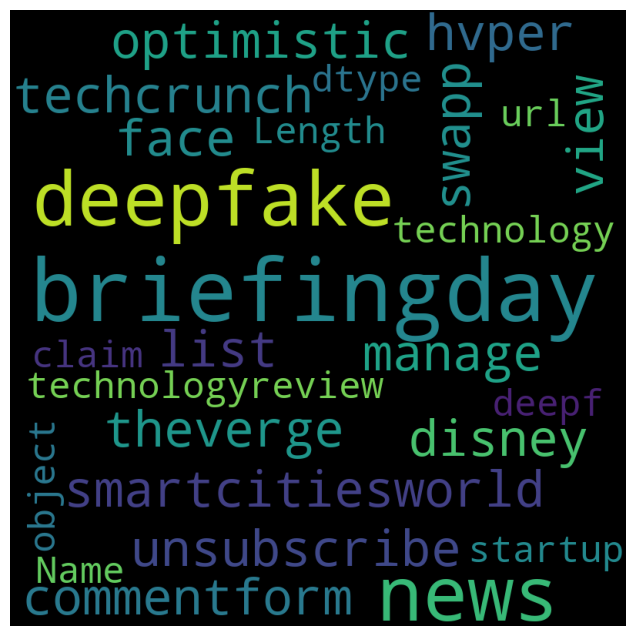

In [60]:
wordcloud = WordCloud(width=800,
                      height=800,
                      background_color="black",
                      max_words=1000,
                      min_font_size=20,
                      random_state=18).generate(str(df["url"]))

fig = plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## vectorizamos

El último paso antes de entrenar el modelo es convertirlo en números, ya que los modelos no pueden entrenar con categorías textuales.

In [61]:
tokens_list = df["url"]
tokens_list = [" ".join(tokens) for tokens in tokens_list]

vectorizer = TfidfVectorizer(max_features=5000,
                             max_df=0.8,
                             min_df=5)

X = vectorizer.fit_transform(tokens_list).toarray()
y = df["is_spam"]

X[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(5, 546))

In [62]:
X.shape

(2369, 546)

`TfidfVectorizer` convierte una colección de documentos de texto brutos en una matriz de características de TF-IDF.

TF-IDF es una medida que cuantifica la importancia de una palabra en un documento en relación con un corpus. Se compone de dos términos:

- **TF** (*Term Frequency*): Es la frecuencia de una palabra en un documento.
- **IDF** (*Inverse Document Frequency*): Mide la importancia del término en el corpus. Un término que aparece en muchos documentos puede no ser tan informativo.

Por lo tanto, al usar `TfidfVectorizer`, transformamos una colección de documentos de texto en una matriz numérica que representa la importancia relativa de cada palabra en cada documento, en relación con el corpus entero.

Esta matriz es comúnmente utilizada como entrada para algoritmos de aprendizaje automático, especialmente en tareas de procesamiento de lenguaje natural como clasificación de texto.

# Modelado

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=18)
model = SVC(kernel="linear",
            random_state=18)
model.fit(X_train, y_train)

,C,1.0
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [64]:
y_pred = model.predict(X_test)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,

In [65]:
accuracy_score(y_test, y_pred)

0.9219409282700421

## mejora del modelo

In [66]:
# Hiperparámetros CORREGIDOS para SVC
hyperparams_svc = {
    "C": np.logspace(-2, 2, 5),  # 0.01, 0.1, 1, 10, 100
    "kernel": ['linear', 'rbf'],
    "gamma": np.logspace(-3, 1, 5), # 0.001, 0.01, 0.1, 1, 10
    "random_state": [18]
}

# Inicializamos la búsqueda con el modelo SVC
random_search = RandomizedSearchCV(
    SVC(),  # Usamos una instancia de SVC
    hyperparams_svc,
    n_iter=10,  # Número de combinaciones a probar (ejemplo)
    cv=5,       # Cross-validation de 5 pliegues
    scoring='accuracy', # Métrica a optimizar
    random_state=18
)

# Sustituye X_train, y_train con tus datos
random_search.fit(X_train, y_train)

random_search.best_params_


{'random_state': 18,
 'kernel': 'linear',
 'gamma': np.float64(1.0),
 'C': np.float64(1.0)}

In [67]:
# Entrenamiento del clasificador
model = SVC(random_state = 18,
            kernel = 'linear',
            gamma = np.float64(1.0),
            C= np.float64(1.0))
model.fit(X_train, y_train)

# Predicción
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Métricas
metrics = {"Accuracy Train: ": accuracy_score(y_train, y_pred_train),
           "Accuracy Test ": accuracy_score(y_test, y_pred_test)}

metrics

{'Accuracy Train: ': 0.950395778364116, 'Accuracy Test ': 0.9219409282700421}

In [ ]:
# Definimos los parámetros que queremos ajustar a mano
hyperparams = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
               'penalty': ['l1', 'l2', 'elasticnet', None],
               'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

# Inicializamos la cuadrícula
grid = GridSearchCV(model,
                    hyperparams,
                    scoring="accuracy",
                    cv=5)
grid

grid.fit(X_train_cat_le_scaled, y_train)

grid.best_params_

## Predicción de un nuevo texto

In [68]:
# new_message = "It's Time to Spin to Win: 100 Free Spins Await at Titan Spins! Experience the Titan Rush: Claim 100 Free Spins Now!"
new_message = """
We know you’re not working. That might win you AirPods 4!
Skipped out early, napped at your desk, or “worked” from home? We won’t judge! Tell us how you really take breaks or sneak in some downtime during work hours.

Share your “ghost vacation” style and try your luck at winning Apple AirPods 4! It’s just a quick 3-minute survey—that’s all it takes.

Take 3-Minute Survey >
The survey ends on July 28th, so make sure to reply before then to have a shot at winning. [Terms apply]

Thank you and hav
"""

# Aplicar preprocesamiento y lematización
processed_message = preprocess_text(new_message)
lemmatized_message = lemmatize_text(processed_message, lemmatizer)

# Unir tokens en una sola cadena
lemmatized_message = " ".join(lemmatized_message)

# Vectorizamos
vectorized_message = vectorizer.transform([lemmatized_message]).toarray()

# Realizar predicción
prediction = model.predict(vectorized_message)

# Mostrar resultado
f'Predicción: {"Spam" if prediction[0] == 1 else "No Spam"}'

'Predicción: No Spam'